# MODULES AND CONSTANTS

### MODULES, IMPORTS AND LIBRARIES

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### CONSTANTS

In [15]:
INPUT_FILE = 'data.txt'

# DATASET LOAD

Load the synthetic 2-D dataset containing Gaussian clusters

In [16]:
def readData(path:str)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=path, header=0)

# DATA PLOTTING

Plot the data points as a scatter chart using the Matplotlib library. At first sight, you should see
15 different globular clusters. <br>Given this distribution, which could be the most suitable clustering
technique among the ones that you known? Why?

In [20]:
def plotPoints(df:pd.DataFrame)->None:
    plt.figure(figsize=(10,10))
    plt.scatter(df['x'], df['y'])
    plt.show()

# MAIN FUNCTION

This is the main function of the program, it does:
<ol>
<li>Loads the dataset as a dataframe</li>
<li></li>
<li></li>
<li></li>
<li></li>
<li></li>
</ol>

In [21]:
df = readData(INPUT_FILE)

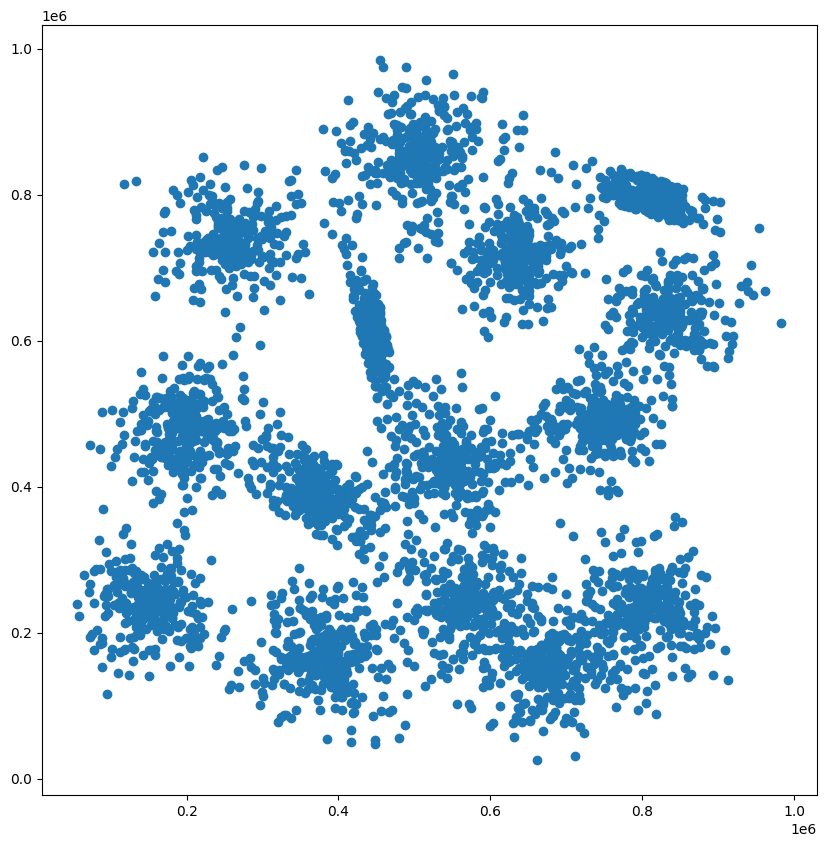

In [22]:
plotPoints(df)